In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import os
from PIL import Image
from scipy.stats import multivariate_normal

# K Means Implementation

In [2]:
def euclidean(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))
def nearest_center(x,centers):
    distance = [euclidean(x,mu) for mu in centers]
    return np.argmin(distance)
def centers_moved_distance(A,B):
    return sum([euclidean(A[i],B[i]) for i in range(len(B))])

In [5]:
def plot_clusters(clusters,centers,X,y,t):
    fig = plt.figure(figsize=(10, 10))
    for index in clusters:
        if not index: continue
        points = X[index].T
        plt.scatter(*points,s=140,alpha=0.8)
        for i in index:
            a,b = X[i]
            plt.text(a,b, str(y[i]), ha='center', va='center', fontsize=14,color="w")
            
    for j,mu in enumerate(centers):
        plt.scatter(*mu, color="red", linewidth=.3)
        plt.text(mu[0], mu[1], f"{chr(65+j)}", ha="center", va="center", fontsize=50,color="black")
    plt.title(f"iteration {t}")
    plt.savefig(f'bookdata/km/figure{t}.png')
    plt.close()

In [7]:
def KMeans(X,y,K,max_steps=101):
    N = len(X)
    centers = [X[i] for i in np.random.choice(N,K)]
    px = np.clip(X,-100,100)
    for t in range(max_steps):
        clusters = [[] for _ in range(K)]
        for i in range(N):
            mu = nearest_center(X[i],centers)
            clusters[mu].append(i)
        
        plot_clusters(clusters,centers,px,y,t) # for viz
        
        prev_centers = centers.copy()
        for j,cluster in enumerate(clusters):
            centers[j] = np.mean(X[cluster],axis=0)
            
        if centers_moved_distance(prev_centers,centers) == 0: break # algorithm converged
    plot_clusters(clusters,centers,px,y,"Final")
    return centers 

# EM for Gaussian Mixture Model implementation

In [8]:
def plot_clusters_g(X,y, means, covs,t):
    fig = plt.figure(figsize=(10,10))
    K = len(means)
    for i in range(len(X)):
        a,b = X[i]
        plt.text(a,b, str(y[i]), ha='center', va='center', fontsize=14,color="w")
        
    plt.scatter(X[:, 0], X[:, 1], alpha=0.8,s=140)
    for k in range(K):
        mean = means[k]
        cov = covs[k]
        plt.text(mean[0], mean[1], f"{chr(65+k)}", ha="center", va="center", fontsize=50,color="black")
        eigvals, eigvecs = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(*eigvecs[::-1, 0]))
        width, height = 2 * np.sqrt(eigvals)
        ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color='red', alpha=1)
        ell.set_facecolor('none')
        plt.gca().add_artist(ell)
    plt.title(f"Iteration {t}")
    plt.savefig(f'bookdata/em/figure{t}.png')
    plt.close()

In [9]:
class GMM:
    def __init__(self, k, max_iter=101):
        self.k = k
        self.max_iter = max_iter
    
    def fit(self, X,y):
        n_samples, n_features = X.shape
        px = np.clip(X,-100,100)
        # initialize parameters
        self.pi = np.ones(self.k) / self.k
        self.mu = np.random.rand(self.k, n_features)
        self.cov = np.zeros((self.k, n_features, n_features))
        for i in range(self.k):
            self.cov[i] = np.eye(n_features)
        
        for t in range(self.max_iter):
            plot_clusters_g(px,y,self.mu,self.cov,t)
            # E-step
            r_ic = np.zeros((n_samples, self.k))
            for j in range(self.k):
                r_ic[:,j] = self.pi[j] * multivariate_normal(self.mu[j], self.cov[j]).pdf(X)
            r_ic = r_ic / np.sum(r_ic, axis=1, keepdims=True)
            
            # M-step
            N_c = np.sum(r_ic, axis=0)
            self.pi = N_c / n_samples
            for j in range(self.k):
                self.mu[j] = np.sum(X * r_ic[:,j].reshape(-1,1), axis=0) / N_c[j]
                diff = X - self.mu[j]
                self.cov[j] = np.dot(r_ic[:,j] * diff.T, diff) / N_c[j]
        
        plot_clusters_g(px,y,self.mu,self.cov,"Final")
        
    def predict(self, X):
        n_samples = X.shape[0]
        y_pred = np.zeros(n_samples)
        for i in range(n_samples):
            probs = np.zeros(self.k)
            for j in range(self.k):
                probs[j] = self.pi[j] * multivariate_normal(self.mu[j], self.cov[j]).pdf(X[i])
            y_pred[i] = np.argmax(probs)
        return y_pred

# Importing Our Datasets and Visualizing the Algorithms

## First: PCA applied digits data set (Not a good normal distribution)

In [7]:
data = pd.read_csv("data/digits_2f.csv")
data.head()

,f1,f2,number
0,-1.25946,21.27488,0
1,7.95761,-20.76870,1
2,6.99192,-9.95598,2
3,-15.90610,3.33246,3
4,23.30687,4.26906,4


In [8]:
data = data.to_numpy()
X,y = data[:,:-1],data[:,-1].astype(int)

In [9]:
clusters = 10

In [10]:
# Kmeans
centers = KMeans(X,y,clusters)

In [11]:
em_gmm = GMM(clusters)
em_gmm.fit(X,y)

In [13]:
import glob
import re

def makegif(file_pattern,out_path,duration=100):
    file_list = glob.glob(file_pattern)
    regex = re.compile(r"\d+")
    file_list = [(filename, int(regex.search(filename).group()) if regex.search(filename) else float('inf')) for filename in file_list]
    file_list.sort(key=lambda x: x[1])
    file_list = [x[0] for x in file_list]
    with Image.open(file_list[0]) as im:
        width, height = im.size

    gif = Image.new("RGB", (width, height))

    images = []
    for filename in file_list:
        with Image.open(filename) as im:
            images.append(im.convert("RGB"))
    gif.save(out_path, save_all=True, append_images=images, duration=duration, loop=0)

In [29]:
makegif("bookdata/km/*png","bookdata/km_animation.gif",200)

![KM Animation](bookdata/km_animation.gif)

In [30]:
makegif("bookdata/em/*png","bookdata/em_animation.gif",100)

![KM Animation](bookdata/em_animation.gif)

## Second: Synthetic Data Sampled from N different Gaussian

In [10]:
data = pd.read_csv("data/synth_7g.csv")

In [11]:
data.head()

,f1,f2,target
0,13.73692,0.60165,0
1,14.06206,0.49744,0
2,12.98572,-0.69923,0
3,17.02274,5.30995,0
4,14.20636,0.59243,0


In [12]:
data = data.to_numpy()
X,y = data[:,:-1].astype(float),data[:,-1].astype(int)

[]

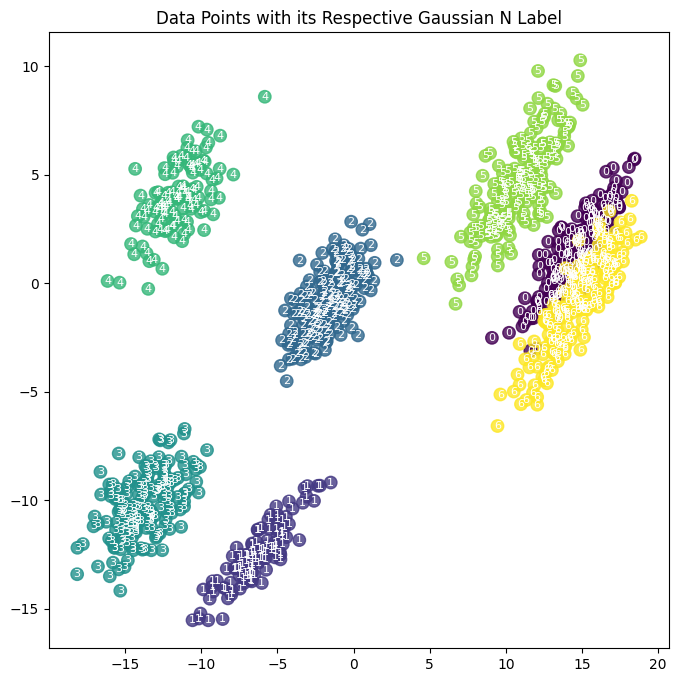

In [19]:
fig = plt.figure(figsize=(8,8))
plt.scatter(X[:,0],X[:,1],c=y,s=80,alpha=0.8)
for i in range(len(X)):
    plt.text(*X[i], str(y[i]), ha='center', va='center', fontsize=8,color="w")
plt.title("Data Points with its Respective Gaussian N Label")
plt.plot()

In [14]:
clusters = 7

In [15]:
# Kmeans
centers2 = KMeans(X,y,clusters)

In [16]:
makegif("bookdata/km/*png","bookdata/km_animationG7.gif",300)

![KM Animation](bookdata/km_animationG7.gif)

In [17]:
em_gmm2 = GMM(clusters)
em_gmm2.fit(X,y)

In [18]:
makegif("bookdata/em/*png","bookdata/em_animationG7.gif",100)

![EM Animation](bookdata/em_animationG7.gif)

Here we can see that GMM made a better prediction, because the data is sampled from Gaussian distribution.